<a href="https://colab.research.google.com/github/cnovak232/DL_Speech_Enhancement/blob/main/DL_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Data by cloning the repo - easiest way to access shared data

In [ ]:
!git clone https://github.com/cnovak232/DL_Speech_Enhancement.git


Cloning into 'DL_Speech_Enhancement'...
remote: Enumerating objects: 16500, done.
remote: Counting objects: 100% (5820/5820), done.
remote: Compressing objects: 100% (5794/5794), done.
remote: Total 16500 (delta 30), reused 5811 (delta 25), pack-reused 10680
Receiving objects: 100% (16500/16500), 3.44 GiB | 46.52 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (16398/16398), done.


In [ ]:
!pip install PyWavelets

Define some helper function for plotting and playing audio

Also implemented the DWT and STDCT with class wrappers

Create a wrapper for the librosa STFT

In [ ]:
import torch
import torchaudio as ta
from IPython.display import Audio, display
import matplotlib
import matplotlib.pyplot as plt
import pywt
import librosa
import numpy as np
import scipy

# helper functions for audio and what not
# mostly taken for torchaudio tutorials 

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block=False)

def get_spectrogram(
    waveform = None,
    n_fft = 512,
    win_len = None,
    hop_len = None,
    power = 1.0 ):
    spectrogram = ta.transforms.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power )
    
    return spectrogram(waveform)

def plot_spectrogram(spec, type = "amplitude", title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    toDb = ta.transforms.AmplitudeToDB(type)
    im = axs.imshow(toDb(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


class STFT(object):
    def __init__(self, n_fft, hop_len = None, win_len = None, window = 'hann', 
                 power = 1.0, center = True, pad_mode = 'constant'):
        self.n_fft = n_fft

        if hop_len:
            self.hop_len = hop_len
        else:
            self.hop_len = n_fft // 2
        
        self.win_len = win_len
        self.power = power
        self.window = window
        self.center = center
        self.pad_mode = pad_mode

    def __call__( self, x ):
        x = x.numpy()
        xw = librosa.stft(x, n_fft = self.n_fft, hop_length = self.hop_len, win_length = self.win_len )
        length = self.n_fft // 2 + 1
        xw = xw[:length,:]
        if self.power == 0.0:
            return torch.from_numpy(xw)
        else:
            mag, phase = librosa.magphase(xw, power = self.power)
            return torch.from_numpy( mag )

class ISTFT(object):
    def __init__(self, n_fft, hop_len = None, win_len = None, window = 'hann', center = True):
        self.n_fft = n_fft

        if hop_len:
            self.hop_len = hop_len
        else:
            self.hop_len = n_fft // 2
        
        self.win_len = win_len
        self.window = window
        self.center = center

    def __call__( self, xw, exp_length = None  ):
        xw = xw.numpy()
        x = librosa.istft(xw, n_fft = self.n_fft, hop_length = self.hop_len, 
                         win_length = self.win_len, length = exp_length )
        return torch.from_numpy( x )
        

class DWT(object):
    def __init__(self, name, level):
        self.name = name
        self.level = level

    def __call__(self, x):
        coeffs = pywt.wavedec(x, self.name, level=self.level,mode='per')
        xdwt = torch.empty(0)
        for band in coeffs:
            torch.from_numpy(band)
            xdwt = torch.cat( (xdwt, torch.from_numpy(band)), dim=1)
        return xdwt

class IDWT(object):
    def __init__(self, name, level):
        self.name = name
        self.level = level

    def __call__(self, xdwt):
        length = xdwt.shape[1]
        coeffs = []
        for idx in range(self.level):
            hlen = length // 2
            coeffs.append( xdwt[:,hlen:length].numpy() )
            length = hlen

        coeffs.append( xdwt[:,:length].numpy() )
        coeffs.reverse()

        xr = pywt.waverec(coeffs, self.name, mode='per')
        return torch.from_numpy(xr) 

def sdct(signal, frame_length, frame_step, window="hamming"):
    """Compute Short-Time Discrete Cosine Transform of `signal`.
    Parameters
    ----------
    signal : Time-domain input signal of shape `(n_samples,)`.
    frame_length : Window length and DCT frame length in samples.
    frame_step : Number of samples between adjacent DCT columns.
    window : Window specification passed to ``librosa.filters.get_window``.
        Default: "hamming".  Window to use for DCT.
    Returns
    -------
    dct : Real-valued F-T domain DCT matrix of shape `(frame_length, n_frames)`
    """
    sig_len = signal.shape[1]

    ovr_len = frame_length - frame_step
    extra = (frame_length - ovr_len) - np.fmod( (sig_len - ovr_len), (frame_length - ovr_len) )
    new_len = sig_len + extra
    signal = librosa.util.fix_length(signal,size = new_len, axis = 1 )
    framed = librosa.util.frame(signal, frame_length=frame_length, hop_length = frame_step )
    if window is not None:
        window = librosa.filters.get_window(window, frame_length, fftbins=True).astype(
            signal.dtype
        )
        framed = framed * window[:, np.newaxis]
    return scipy.fft.dct(framed,norm="ortho", axis=-2)


def isdct(dct, *, frame_step, frame_length=None, window="hamming"):
    """Compute Inverse Short-Time Discrete Cosine Transform of `dct`.
    Parameters other than `dct` are keyword-only.
    Parameters
    ----------
    dct : DCT matrix from `sdct`.
    frame_step : Number of samples between adjacent DCT columns (should be the
        same value that was passed to `sdct`).
    frame_length : Ignored. Window length and DCT frame length in samples.
        Can be None (default) or same value as passed to `sdct`.
    window : Window specification passed to ``librosa.filters.get_window``.
        Default: "hamming".  Window to use for IDCT.
    Returns
    -------
    signal : Time-domain signal reconstructed from `dct` of shape `(n_samples,)`.
    """
    frame_length2, n_frames = dct.shape
    assert frame_length in {None, frame_length2}
    signal = overlap_add(
        scipy.fft.idct(dct, norm="ortho", axis=-2), frame_step=frame_step
    )
    if window is not None:
        window = librosa.filters.get_window(window, frame_length2, fftbins=True).astype(
            dct.dtype
        )
        window_frames = np.tile(window[:, np.newaxis], (1, n_frames))
        window_signal = overlap_add(window_frames, frame_step=frame_step)
        signal = signal / window_signal
    return signal


def overlap_add(framed, *, frame_step, frame_length=None):
    """Overlap-add ("deframe") a framed signal.
    Parameters other than `framed` are keyword-only.
    Parameters
    ----------
    framed : array_like of shape `(..., frame_length, n_frames)`.
    frame_step : Overlap to use when adding frames.
    Returns
    -------
    deframed : Overlap-add ("deframed") signal.
        np.ndarray of shape `(..., (n_frames - 1) * frame_step + frame_length)`.
    """
    *shape_rest, frame_length2, n_frames = framed.shape

    assert frame_length in {None, frame_length2}
    deframed_size = (n_frames - 1) * frame_step + frame_length2
    deframed = np.zeros((*shape_rest, deframed_size), dtype=framed.dtype)
    for i in range(n_frames):
        pos = i * frame_step
        deframed[..., pos : pos + frame_length2] += framed[..., i]
    return deframed


class STDCT(object):
    def __init__(self, frame_length, frame_step, window_fn="hamming"):
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.window_fn = window_fn

    def __call__(self, x):
        x = x.numpy()
        x_stdct = sdct( x, self.frame_length, self.frame_step, self.window_fn )
        return torch.from_numpy(x_stdct)

class ISTDCT(object):
    def __init__(self, frame_step, frame_length=None, window_fn="hamming", ):
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.window_fn = window_fn

    def __call__(self, xdct, exp_length = None):
        xdct = xdct.numpy()
        x = isdct( xdct, frame_step = self.frame_step, frame_length = self.frame_length, window = self.window_fn )
        if exp_length:
            x = librosa.util.fix_length(x, size = exp_length, axis = 0 )
        x = torch.from_numpy(x)
        return x.unsqueeze(dim=0)

Define a Custom Dataset class for the Data and read it in

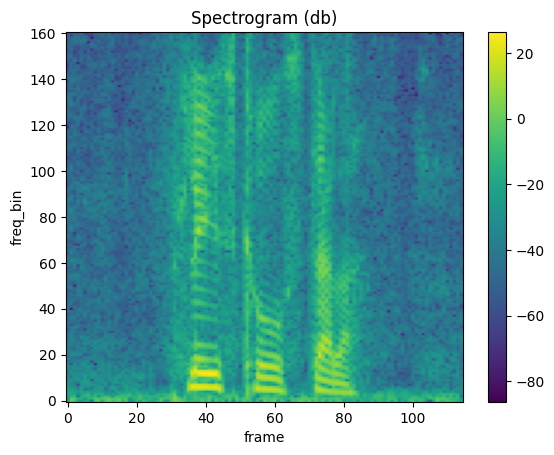

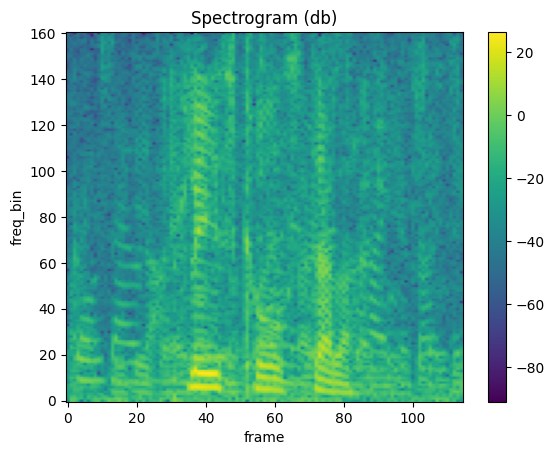

In [ ]:
# read dataset in and downsample / transform / pad if needed
from torch.utils.data import Dataset
import torch
import os

class VoiceBankDemand(Dataset):
    def __init__(self, clean_dir, noisy_dir, list_dir, 
                 data = "train", len_samples = None, downsample = None, 
                 transform = None ):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.list_dir = list_dir
        self.num_samples = len_samples
        self.downsample = downsample
        self.transform = transform
        self.data = data
    
    def __len__(self):
        return len(self.list_dir)

    def __getitem__( self, idx ):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        clean_name = os.path.join( self.clean_dir, self.list_dir[idx] )
        noisy_name = os.path.join( self.noisy_dir, self.list_dir[idx] )
        clean_audio, fs = ta.load(clean_name)
        noisy_audio, fs= ta.load(noisy_name)

        if self.downsample:
            downsampler = ta.transforms.Resample(fs,self.downsample)
            clean_audio = downsampler( clean_audio )
            noisy_audio = downsampler( noisy_audio )

        orig_len = clean_audio.shape[1]

        if self.num_samples:
            # trim or pad audio to fixed length 
            if clean_audio.shape[1] > self.num_samples:
                clean_audio = clean_audio[:,:self.num_samples]
                noisy_audio = noisy_audio[:,:self.num_samples]
            elif clean_audio.shape[1] < self.num_samples:
                pad_len = int( self.num_samples - clean_audio.shape[1] )
                pad = torch.zeros(1,pad_len)
                clean_audio = torch.cat((clean_audio,pad), dim=1)
                noisy_audio = torch.cat((noisy_audio,pad),dim=1)
        
        if self.transform:
                noisy_audio = self.transform( noisy_audio )
                clean_audio = self.transform( clean_audio )

        sample = (clean_audio, noisy_audio, orig_len)

        return sample

train_clean_path = './DL_Speech_Enhancement/clean_trainset_28spk_wav'
train_noisy_path = './DL_Speech_Enhancement/noisy_trainset_28spk_wav'
test_clean_path  = './DL_Speech_Enhancement/clean_testset_wav'
test_noisy_path  = './DL_Speech_Enhancement/noisy_testset_wav'

list_dir_train = os.listdir(train_clean_path)
list_dir_train.sort()
list_dir_test = os.listdir(test_clean_path)
list_dir_test.sort()

target_fs = 8000 # downsample to 8 KHz

spectrogram = ta.transforms.Spectrogram(
    n_fft=320, # size for the CRNN
    power=1.0,
    normalized = False )

WAVE_UNET_LEN = 16384 # length the WaveUNET processing
num_samples_train = WAVE_UNET_LEN * 3
num_samples_test = WAVE_UNET_LEN * 5


# Optional Transfrom to pass to the dataset
stft = STFT(n_fft = 320, power = 1.0)
istft = ISTFT( n_fft = 320 )

wavelet = DWT( name = 'db8', level = 3 )

stdct = STDCT( frame_length = 320, frame_step = 160 )

istdct = ISTDCT( frame_length = 320, frame_step = 160 )

# return turns a tuple of ( clean_data, noisy_data, original_length)
# data type depends on if transform was specified
train_set = VoiceBankDemand( clean_dir = train_clean_path,
                             noisy_dir = train_noisy_path,
                             list_dir = list_dir_train,
                             len_samples = None, # clip or pad samples to be 5s
                             downsample = target_fs, # downsample to 8Khz
                             transform = stft )
"""
# this is for testing
train_set_t = VoiceBankDemand( clean_dir = train_clean_path,
                             noisy_dir = train_noisy_path,
                             list_dir = list_dir_train,
                             len_samples = None, # clip or pad samples to be 5s
                             downsample = target_fs, # downsample to 16Khz
                             transform = None )
"""

# Returns tuple within tuples: clean_data, noisy_data, original length
test_set = VoiceBankDemand( clean_dir = test_clean_path,
                            noisy_dir = test_noisy_path,
                            list_dir = list_dir_test,
                            data = "test",
                            len_samples = None,
                            downsample = target_fs,
                            transform = stft )

#############################################################
# For viewing samples and such
clean, noisy, orig_len = train_set[0]
#clean_t, noisy_t, orig_len = train_set_t[0]

#transform = DWT( name = 'db4', level = 3 )
#inv_transform = IDWT( name = 'db4', level = 3)
#clean_dwt = transform(clean)

#plot_waveform(clean_t,target_fs)
#plot_waveform(clean_t_rec,target_fs)

#clean_test, noisy_test, orig_len = test_set[0]

#noisy_mag, noisy_phase, noisy_audio, norm_val = noisy_test

plot_spectrogram(clean.squeeze())
plot_spectrogram(noisy.squeeze())

#play_audio(clean_t,target_fs)
#play_audio(clean_t_rec,target_fs)

CRNN: Convoluation Encoder/Decoder with LSTM in the middle
Processing spectrogram inputs 

Paper for reference: 
https://web.cse.ohio-state.edu/~wang.77/papers/Tan-Wang1.interspeech18.pdf


In [ ]:
import torch
import torch.nn as nn


class CausalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 2),
            stride=(2, 1),
            padding=(0, 1)
        )
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        self.activation = nn.ELU()

    def forward(self, x):
        """
        2D Causal convolution.
        Args:
            x: [B, C, F, T]
        Returns:
            [B, C, F, T]
        """
        x = self.conv(x)
        x = x[:, :, :, :-1]  # chomp size
        x = self.norm(x)
        x = self.activation(x)
        return x


class CausalTransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last=False, output_padding=(0, 0)):
        super().__init__()
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 2),
            stride=(2, 1),
            output_padding=output_padding
        )
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        if is_last:
            self.activation = nn.ReLU()
        else:
            self.activation = nn.ELU()

    def forward(self, x):
        """
        2D Causal convolution.
        Args:
            x: [B, C, F, T]
        Returns:
            [B, C, F, T]
        """
        x = self.conv(x)
        x = x[:, :, :, :-1]  # chomp size
        x = self.norm(x)
        x = self.activation(x)
        return x


class CRN(nn.Module):
    """
    Input: [batch size, channels=1, T, n_fft]
    Output: [batch size, T, n_fft]
    """

    def __init__(self):
        super(CRN, self).__init__()
        # Encoder
        self.conv_block_1 = CausalConvBlock(1, 16)
        self.conv_block_2 = CausalConvBlock(16, 32)
        self.conv_block_3 = CausalConvBlock(32, 64)
        self.conv_block_4 = CausalConvBlock(64, 128)
        self.conv_block_5 = CausalConvBlock(128, 256)

        # LSTM
        self.lstm_layer = nn.LSTM(input_size=1024, hidden_size=1024, num_layers=2, batch_first=True)

        self.tran_conv_block_1 = CausalTransConvBlock(256 + 256, 128)
        self.tran_conv_block_2 = CausalTransConvBlock(128 + 128, 64)
        self.tran_conv_block_3 = CausalTransConvBlock(64 + 64, 32)
        self.tran_conv_block_4 = CausalTransConvBlock(32 + 32, 16, output_padding=(1, 0))
        self.tran_conv_block_5 = CausalTransConvBlock(16 + 16, 1, is_last=True)

    def forward(self, x):
        self.lstm_layer.flatten_parameters()

        e_1 = self.conv_block_1(x)
        e_2 = self.conv_block_2(e_1)
        e_3 = self.conv_block_3(e_2)
        e_4 = self.conv_block_4(e_3)
        e_5 = self.conv_block_5(e_4)  # [2, 256, 4, 200]

        batch_size, n_channels, n_f_bins, n_frame_size = e_5.shape

        # [2, 256, 4, 200] = [2, 1024, 200] => [2, 200, 1024]
        lstm_in = e_5.reshape(batch_size, n_channels * n_f_bins, n_frame_size).permute(0, 2, 1)
        lstm_out, _ = self.lstm_layer(lstm_in)  # [2, 200, 1024]
        lstm_out = lstm_out.permute(0, 2, 1).reshape(batch_size, n_channels, n_f_bins, n_frame_size)  # [2, 256, 4, 200]

        d_1 = self.tran_conv_block_1(torch.cat((lstm_out, e_5), 1))
        d_2 = self.tran_conv_block_2(torch.cat((d_1, e_4), 1))
        d_3 = self.tran_conv_block_3(torch.cat((d_2, e_3), 1))
        d_4 = self.tran_conv_block_4(torch.cat((d_3, e_2), 1))
        d_5 = self.tran_conv_block_5(torch.cat((d_4, e_1), 1))

        return d_5

WaveU-Net for Speech Denoising

Paper Reference:
https://arxiv.org/pdf/1806.03185.pdf

Code reference for implementation:
https://github.com/haoxiangsnr/Wave-U-Net-for-Speech-Enhancement


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DownSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, dilation=1, kernel_size=15, stride=1, padding=7):
        super(DownSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1)
        )

    def forward(self, ipt):
        return self.main(ipt)

class UpSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=5, stride=1, padding=2):
        super(UpSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

    def forward(self, ipt):
        return self.main(ipt)

class WaveUNet(nn.Module):
    def __init__(self, n_layers=12, channels_interval=24):
        super(WaveUNet, self).__init__()

        self.n_layers = n_layers
        self.channels_interval = channels_interval
        encoder_in_channels_list = [1] + [i * self.channels_interval for i in range(1, self.n_layers)]
        encoder_out_channels_list = [i * self.channels_interval for i in range(1, self.n_layers + 1)]

        self.encoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.encoder.append(
                DownSamplingLayer(
                    channel_in=encoder_in_channels_list[i],
                    channel_out=encoder_out_channels_list[i]
                )
            )

        self.middle = nn.Sequential(
            nn.Conv1d(self.n_layers * self.channels_interval, self.n_layers * self.channels_interval, 15, stride=1,
                      padding=7),
            nn.BatchNorm1d(self.n_layers * self.channels_interval),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        decoder_in_channels_list = [(2 * i + 1) * self.channels_interval for i in range(1, self.n_layers)] + [
            2 * self.n_layers * self.channels_interval]
        decoder_in_channels_list = decoder_in_channels_list[::-1]
        decoder_out_channels_list = encoder_out_channels_list[::-1]
        self.decoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.decoder.append(
                UpSamplingLayer(
                    channel_in=decoder_in_channels_list[i],
                    channel_out=decoder_out_channels_list[i]
                )
            )

        self.out = nn.Sequential(
            nn.Conv1d(1 + self.channels_interval, 1, kernel_size=1, stride=1),
            nn.Tanh()
        )

    def forward(self, input):
        tmp = []
        x = input

        # Up Sampling
        for i in range(self.n_layers):
            x = self.encoder[i](x)
            tmp.append(x)
            # [batch_size, T // 2, channels]
            x = x[:, :, ::2]

        x = self.middle(x)

        # Down Sampling
        for i in range(self.n_layers):
            # [batch_size, T * 2, channels]
            x = F.interpolate(x, scale_factor=2, mode="linear", align_corners=True)
            # Skip Connection
            x = torch.cat([x, tmp[self.n_layers - i - 1]], dim=1)
            x = self.decoder[i](x)

        x = torch.cat([x, input], dim=1)
        output = self.out(x)
        return output

Special loss and collate function for padding and processing batches of spectrograms with different length 

In [ ]:
from torch.nn.utils.rnn import pad_sequence


def loss_function( loss_fn, input, target, mask):
    input = input * mask
    target = target * mask

    return loss_fn(input, target)

def collate_fn_pad(batch):
    """
    Returns:
        [B, F, T (Longest)]
    """
    noisy_list = []
    clean_list = []
    mask_list = []

    for clean, noisy, orig_len, in batch:
        mask = torch.ones(clean.size())
        clean_list.append(clean.squeeze().permute(1,0))  # [1, T] => [T, 1]
        noisy_list.append(noisy.squeeze().permute(1,0))  # [F, T] => [T, F]
        mask_list.append(mask.squeeze().permute(1,0))

    clean_list = pad_sequence(clean_list, batch_first = True).permute(0,2,1) # ([T1, 1], [T2, 1], ...) => [T, B, 1] => [B, 1, T]
    noisy_list = pad_sequence(noisy_list, batch_first = True).permute(0,2,1) # ([T1, F], [T2, F], ...) => [T, B, F] => [B, F, T]
    mask_list  = pad_sequence(mask_list,  batch_first = True).permute(0,2,1)

    return noisy_list.unsqueeze(dim=1), clean_list.unsqueeze(dim=1), mask_list.unsqueeze(dim=1)

Main block for training the model and validation.\
Initializes all training and validation parameters. \
Performs training and validation in one big loop, testing each epoch to track any overfitting and envoking early stopping

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

def train_model( model, dataloader, criterion, optimizer, device ):
    model.train()

    running_loss = 0.0

    # Iterate over data.
    for clean_audio,noisy_audio,orig_len in dataloader:
        # send inputs to gpu
        clean_audio = clean_audio.to(device)
        noisy_audio = noisy_audio.to(device)
        orig_len = orig_len.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        with torch.enable_grad():
            # Send the noisey speech sample through network
            output = model(noisy_audio)

            # compute loss between network output and clean audio
            loss = criterion(output, clean_audio)

            # backward + optimize 
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader.dataset)

    return model, epoch_loss

def test_model( model, device, criterion, dataloader ):
    model.eval() 

    if dataloader.batch_size > 1:
        cleaned_data = torch.empty(0)
    else:
        cleaned_data = []

    running_loss = 0

    for clean_audio, noisy_audio, orig_len in dataloader:
        noisy_audio = noisy_audio.to(device)
        clean_audio = clean_audio.to(device)
        
        with torch.no_grad():
            # forward
            enhanced_data = model(noisy_audio)

            loss = criterion(enhanced_data, clean_audio)

            if dataloader.batch_size > 1:
                cleaned_data = torch.cat( (cleaned_data, enhanced_data.detach().cpu()), 0 )
            else:
                cleaned_data.append( enhanced_data.detach().cpu() )

            running_loss += loss.item()

    test_loss = running_loss / len( dataloader.dataset )

    return cleaned_data, test_loss

# Batch size of 32 for Wave-U-Net
# Batch size of 1 for CRNN (16 not working right)
train_split, val_split = random_split( train_set, [6873, 500])
train_loader = DataLoader(train_split, batch_size = 1, shuffle=True )
val_loader = DataLoader( val_split, batch_size = 1, shuffle=True)

model = CRN() # assign model you want to use

learning_rate = 0.001
num_epochs = 25

criterion = nn.MSELoss()
#criterion = loss_function

optimizer = torch.optim.Adam(model.parameters(),learning_rate)

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

model = model.to(device)

min_val_loss = 10000.0
count = 0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    model, epoch_loss = train_model( model, train_loader, criterion, optimizer, device )
    print('Train Epoch Loss = ', epoch_loss )

    cleaned_data, val_loss = \
        test_model( model, device, criterion, val_loader )
    print('Val Epoch Loss = ', val_loss )

    if val_loss  < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), './best_model')
        count = 0
    else:
        count += 1

    if count > 3:
        print("Early Stopping Criteria Hit")
        break;


Epoch 0/24
----------
Train Epoch Loss =  0.04846848980896961
Val Epoch Loss =  0.053030681982636454
Epoch 1/24
----------
Train Epoch Loss =  0.03331933229057712
Val Epoch Loss =  0.04717477342765778
Epoch 2/24
----------
Train Epoch Loss =  0.028748922573504018
Val Epoch Loss =  0.04355510368058458
Epoch 3/24
----------
Train Epoch Loss =  0.02598153312348949
Val Epoch Loss =  0.04341039177495986
Epoch 4/24
----------
Train Epoch Loss =  0.024316680867195933
Val Epoch Loss =  0.046070033187046645
Epoch 5/24
----------
Train Epoch Loss =  0.022805654272963126
Val Epoch Loss =  0.04521768693765625
Epoch 6/24
----------
Train Epoch Loss =  0.02168235718074451
Val Epoch Loss =  0.042675568368751554
Epoch 7/24
----------
Train Epoch Loss =  0.020709619577638706
Val Epoch Loss =  0.03976218985021114
Epoch 8/24
----------
Train Epoch Loss =  0.019809016326106176
Val Epoch Loss =  0.04654266989044845
Epoch 9/24
----------
Train Epoch Loss =  0.019272648103183677
Val Epoch Loss =  0.038934547

Use the saved parameters from the best model after training to test on the test set

In [ ]:

best_model = CRN() # default
# use batch size 32 for Wave-U-Net
test_loader = DataLoader( test_set, batch_size=1 )

best_model.load_state_dict(torch.load('./best_model'))
best_model = best_model.to(device)

cleaned_data, test_loss = \
    test_model( best_model, device, criterion, test_loader )

print(test_loss)

0.019409085546215562


In [ ]:
!pip install torchmetrics[audio]
!pip install pesq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7792 sha256=06630f00d8dd2d158f2949d0dd698d909b8c563ce6e82fdb1a3e4cc1bbc905ba
  Stored in directory: /root/.cache/pip/wheels/3b/ca/9e/5b5d6e5e109322303b50d21918ad2bd7d50a2a0775c11e08e8
Successfully built pystoi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=255315 sha256=315a167593767c647c1a1d561d50e092b1a9d910e0ea2121ec5b8c76495e356a
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


Loop through testing samples and evaluate enhanced data against clean data

In [ ]:
from torchmetrics import SignalNoiseRatio
from pesq import pesq


def asses_metrics( test_wavs, cleaned_data, test_complex = None, inv_transform = None ):

    SNR = SignalNoiseRatio(zero_mean=True)

    snr_vals_noisy = torch.empty(len(test_set))
    pesq_vals_noisy = torch.empty(len(test_set))
    snr_vals = torch.empty(len(test_set))
    pesq_vals = torch.empty(len(test_set))
    cleaned_waveforms = []

    for i in range( len(test_wavs) ):
        clean_wav,noisy_wav,orig_len = test_wavs[i]
        clean_data = cleaned_data[i]

        if inv_transform:
            if test_complex:
                _,noisy_complex, _ = test_complex[i]
                phase = torch.angle( noisy_complex )
                clean_data = torch.polar(clean_data.squeeze(), phase)

            enhanced_audio = inv_transform( clean_data, clean_wav.shape[1] )

        if enhanced_audio.shape[1] > orig_len:
            enhanced_audio = enhanced_audio[:,:orig_len]
            noisy_wav = noisy_wav[:,:orig_len]
            clean_wav = clean_wav[:,:orig_len]

        cleaned_waveforms.append( enhanced_audio )

        snr_vals[i] = SNR(enhanced_audio, clean_wav)
        pesq_vals[i] = pesq( target_fs, enhanced_audio.squeeze().numpy(), clean_wav.squeeze().numpy(), "nb")

        snr_vals_noisy[i] = SNR(noisy_wav, clean_wav)
        pesq_vals_noisy[i] = pesq( target_fs, noisy_wav.squeeze().numpy(), clean_wav.squeeze().numpy(), "nb")

    return cleaned_waveforms, snr_vals, pesq_vals, snr_vals_noisy, pesq_vals_noisy

# Specificy an inverse transforms to pass for asses metrics
#inv_transform = ISTDCT( frame_length=161, frame_step = 80)
#inv_transform = ta.transforms.InverseSpectrogram( 
#    n_fft = 320,
#    normalized = False)
istft = ISTFT( n_fft = 320 )

complex_spec = STFT(n_fft = 320, power = 0.0)

"""
complex_spec = ta.transforms.Spectrogram(
    n_fft=320,
    power=None,
    normalized = False ) # return complex spectrum
"""

# Compute the complex spectrum to extract phase info when reconstructing
test_complex = VoiceBankDemand( clean_dir = test_clean_path,
                             noisy_dir = test_noisy_path,
                             list_dir = list_dir_test,
                             data = "test",
                             len_samples = None,
                             downsample = target_fs,
                             transform = complex_spec )

# clean waves for comparison
test_wavs = VoiceBankDemand( clean_dir = test_clean_path,
                             noisy_dir = test_noisy_path,
                             list_dir = list_dir_test,
                             data = "test",
                             len_samples = None,
                             downsample = target_fs,
                             transform = None )

cleaned_waveforms, snr_vals, pesq_vals, snr_vals_noisy, pesq_vals_noisy = \
    asses_metrics(test_wavs,cleaned_data, test_complex = test_complex, inv_transform = istft )



Compute average and best SNR and PESQ improvements

In [ ]:
SNR_imp = snr_vals - snr_vals_noisy
PESQ_imp = pesq_vals - pesq_vals_noisy
print("Average PESQ Enhanced", pesq_vals.sum() / len(pesq_vals) )
print("Average PESQ Noisy", pesq_vals_noisy.sum() / len(pesq_vals_noisy) )

avg_SNR_imp = SNR_imp.sum() / len(SNR_imp)
avg_PESQ_imp = PESQ_imp.sum() / len(PESQ_imp)

peak_SNR_imp = SNR_imp.max()
peak_snr_ind = SNR_imp.argmax()
peak_PESQ_imp = PESQ_imp.max()
peak_PESQ_ind = PESQ_imp.argmax()


print("Average SNR Improvement = ", avg_SNR_imp )
print("Average PESQ Improvement = ", avg_PESQ_imp )

print("Best SNR Improvement = ", peak_SNR_imp )
print("Best PESQ Improvment = ", peak_PESQ_imp )


# use if using magnitude spectrograms
#plot_spectrogram(cleaned_data[0].squeeze())
#plot_spectrogram(test_set[0][0][1].squeeze())

play_audio(test_wavs[176][1],target_fs) # play noisy test sample
play_audio(cleaned_waveforms[176],target_fs)


Average PESQ Enhanced tensor(2.6272)
Average PESQ Noisy tensor(2.7802)
Average SNR Improvement =  tensor(5.4977)
Average PESQ Improvement =  tensor(-0.1530)
Best SNR Improvement =  tensor(18.9250)
Best PESQ Improvment =  tensor(1.3954)
